# Import Library

In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, MobileNetV2 ,InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Read Dataset

In [108]:
df = pd.read_csv("data.csv")
df["file_path"] = df["mood"]+'/'+df["filename"].str.split(".",expand=True)[0]+".png"

In [109]:
df.head()

,filename,mood,file_path
0,A Song For Mama_0.wav,Romance,Romance/A Song For Mama_0.png
1,A Song For Mama_1.wav,Romance,Romance/A Song For Mama_1.png
2,A Song For Mama_2.wav,Romance,Romance/A Song For Mama_2.png
3,A Song For Mama_3.wav,Romance,Romance/A Song For Mama_3.png
4,A Song For Mama_4.wav,Romance,Romance/A Song For Mama_4.png


In [110]:
df["mood"].value_counts()

Romance    395
Party      368
Chill      347
Anxious    321
Sad        310
Focus      301
Name: mood, dtype: int64

# Define Constant

In [111]:
base_dir = "spectogram/"
IMAGE_SIZE = 224
BATCH_SIZE = 256

# Split Dataset

In [112]:
# Train 0.75
# Validate 0.15
# Test 0.10
df_train,  test_df = train_test_split(df,train_size=0.9,random_state=1941,stratify=df['mood'])
train_df, val_df = train_test_split(df_train,test_size=1/6,random_state=1941,stratify=df_train['mood'])

# Load image to generator

In [113]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255,)

train_data = train_image_generator.flow_from_dataframe(
    train_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 1530 validated image filenames belonging to 6 classes.


In [114]:
val_image_generator = ImageDataGenerator(rescale=1./255)

val_data = val_image_generator.flow_from_dataframe(
    val_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 307 validated image filenames belonging to 6 classes.


In [115]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data = test_image_generator.flow_from_dataframe(
    test_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 205 validated image filenames belonging to 6 classes.


## Check Class indices

In [116]:
train_data.class_indices

{'Anxious': 0, 'Chill': 1, 'Focus': 2, 'Party': 3, 'Romance': 4, 'Sad': 5}

# Create model

In [117]:
def get_mobilenet_model():
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5)(headModel)
  headModel = Dense(32, activation="relu")(headModel)
  headModel = Dense(6, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [118]:
model = get_mobilenet_model()
model_name = "model.h5"

In [119]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

In [120]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/"+model_name, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [130]:
EPOCHS = 100
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


2022-03-12 21:12:48.407852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8732

2022-03-12 21:12:57.156693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 11s 2s/step - loss: 0.4039 - accuracy: 0.8732 - val_loss: 1.0004 - val_accuracy: 0.6482
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.3798 - accuracy: 0.8765 - val_loss: 0.9899 - val_accuracy: 0.6645
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.3691 - accuracy: 0.8817 - val_loss: 0.9732 - val_accuracy: 0.6710
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 0.3473 - accuracy: 0.8889 - val_loss: 1.0099 - val_accuracy: 0.6580
Epoch 5/100
6/6 [==============================] - 9s 2s/step - loss: 0.3298 - accuracy: 0.8869 - val_loss: 1.0418 - val_accuracy: 0.6547
Epoch 6/100
6/6 [==============================] - 9s 2s/step - loss: 0.3210 - accuracy: 0.9000 - val_loss: 0.9856 - val_accuracy: 0.6743
Epoch 7/100
6/6 [==============================] - 9s 2s/step - loss: 0.3084 - accuracy: 0.9059 - val_loss: 1.0044 - val_accuracy: 0.6710
Epoch 8/100
6/6 [==========================

# Save Model

In [133]:
model.save("models/"+model_name)

# Load Model

In [127]:
model = load_model("models/"+model_name)

# Evaluate Model

In [131]:
import os
confusion_matrix_s = np.zeros(36).reshape(6,6)
true = 0
class_labels = list(train_data.class_indices.keys())
count = 0
for i in test_df.itertuples():
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(base_dir,i[3]), target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255
    img_array = img_array.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
    predictions = model.predict(img_array)
    pred_class = class_labels[np.argmax(predictions)]   
    row = class_labels.index(pred_class)
    col = class_labels.index(i[2])
    confusion_matrix_s[row][col] += 1
    if pred_class == i[2]:
        true+=1
    count += 1
    if count % 10 == 0:
        print("Done: ",count, "Acc:", round(true/count,4))
print("Accuracy: ", round(true/count,4))

Done:  10 Acc: 0.5
Done:  20 Acc: 0.6
Done:  30 Acc: 0.6667
Done:  40 Acc: 0.675
Done:  50 Acc: 0.68
Done:  60 Acc: 0.7167
Done:  70 Acc: 0.6714
Done:  80 Acc: 0.6875
Done:  90 Acc: 0.6889
Done:  100 Acc: 0.67
Done:  110 Acc: 0.6636
Done:  120 Acc: 0.675
Done:  130 Acc: 0.6846
Done:  140 Acc: 0.6786
Done:  150 Acc: 0.6733
Done:  160 Acc: 0.675
Done:  170 Acc: 0.6706
Done:  180 Acc: 0.6833
Done:  190 Acc: 0.6895
Done:  200 Acc: 0.675
Accuracy:  0.6732


Accuracy:  0.6731707317073171


/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_4774/980666082.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",*class_labels])
/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_4774/980666082.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["",*class_labels])


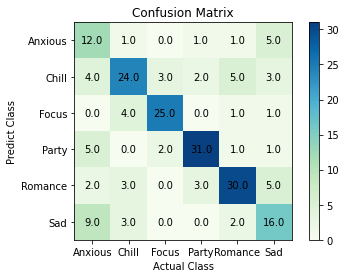

In [132]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Confusion Matrix")
heatmap = ax.matshow(confusion_matrix_s,cmap='GnBu')
plt.xlabel("Actual Class")
plt.ylabel("Predict Class")
plt.colorbar(heatmap)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["",*class_labels])
ax.set_yticklabels(["",*class_labels])
for (i, j), z in np.ndenumerate(confusion_matrix_s):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
accuracy = np.trace(confusion_matrix_s)/np.sum(confusion_matrix_s)
print("Accuracy: ", accuracy)